In [2]:
%cd ..

c:\Users\esper\Desktop\injury_forecasting


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.plotting import set_plot_style
from src.config import DATA_DIR, FIGURES_DIR
set_plot_style()

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv(DATA_DIR / "processed" /"federal_df.csv", parse_dates=["EventDate"])

C:\Users\esper\AppData\Local\Temp\ipykernel_22564\252222813.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_DIR / "processed" /"federal_df.csv", parse_dates=["EventDate"])


In [6]:
df = df[df['EventDate'] < '2025-01-01']
df.tail()

,ID,UPA,EventDate,Employer,Address1,City,State,Zip,Latitude,Longitude,...,Part of Body Title,Event,EventTitle,Source,SourceTitle,FederalState,Year,NatureGroup,NatureGroupLabel,BodyPartDivision
94919,20241211974,2247596,2024-12-31,"Lowe's Companies, Inc.",230 East Hanover Ave,MORRIS PLAINS,NEW JERSEY,7950.0,40.81,-74.47,...,Other finger(s) n.e.c.,6612,Injured by object pushed or pulled by person,730,Portable ladders and stairs unspecified,1,2024,12,Open wounds,Upper Extremities
94920,20241211975,2247521,2024-12-31,Capital Electric Line Builders,1201 East Street,PARKVILLE,MISSOURI,64152.0,39.19,-94.68,...,Multiple regions of the head,4110,Fall to lower level from collapsing structure...,6352,Utility poles,1,2024,18,Burns/Corrosions/Scalds,Head
94921,20241211976,2248165,2024-12-31,Half Off Fireworks LLC,302 McCright,VICTORIA,TEXAS,77901.0,28.81,-97.02,...,Multiple body parts n.e.c.,311,Intentionally set explosion,1122,Fireworks,1,2024,15,Sprains/Strains/Tears,Multiple Body Parts
94922,20241211977,2247326,2024-12-31,Mill Steel Corporation,250 Ocean Rd,GREENLAND,NEW HAMPSHIRE,3840.0,43.03,-70.81,...,Skull,4312,Fall on same level due to slip or trip,660,"Ground, travel, and support surfaces unspeci...",1,2024,12,Open wounds,Head
94923,20241211979,2247400,2024-12-31,"Tropicana Manufacturing Company, Inc.",1001 13TH AVENUE EAST,BRADENTON,FLORIDA,34208.0,27.48,-82.55,...,Body systems and other part(s) of body,558,Exposure to harmful substance multiple routes...,1419,Oxidizing substances and organic peroxides n...,1,2024,18,Burns/Corrosions/Scalds,Multiple Body Parts


In [7]:
df = df.rename(columns={"EventDate": "Date"})
df["Date"] = pd.to_datetime(df["Date"])

In [8]:
df['Date'] = df['Date'].dt.to_period('W').dt.start_time


In [29]:
weekly_counts = (
    df.assign(Date=df["Date"].dt.to_period("W-MON").dt.to_timestamp(how="end").dt.normalize())
      .groupby(["State", "Date"], as_index=False)
      .agg(Hospitalized=("Hospitalized", "sum"))
)

# 2) Build complete state × week index
states = weekly_counts["State"].unique()
weeks = pd.period_range(
    weekly_counts["Date"].min().to_period("W-MON"),
    weekly_counts["Date"].max().to_period("W-MON"),
    freq="W-MON"
).to_timestamp(how="end").normalize()

full_index = pd.MultiIndex.from_product(
    [states, weeks],
    names=["State", "Date"]
).to_frame(index=False)

# 3) Merge and fill true zeros
weekly_complete = (
    full_index
    .merge(weekly_counts, on=["State", "Date"], how="left")
    .fillna({"Hospitalized": 0})
)

In [10]:
weekly_complete.head()

,State,Date,Hospitalized
0,ALABAMA,2014-12-23,0.0
1,ALABAMA,2014-12-30,1.0
2,ALABAMA,2015-01-06,5.0
3,ALABAMA,2015-01-13,5.0
4,ALABAMA,2015-01-20,3.0


In [11]:
weekly_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15690 entries, 0 to 15689
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   State         15690 non-null  object        
 1   Date          15690 non-null  datetime64[ns]
 2   Hospitalized  15690 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 367.9+ KB


In [12]:
weekly_complete.tail()

,State,Date,Hospitalized
15685,WISCONSIN,2024-11-26,6.0
15686,WISCONSIN,2024-12-03,4.0
15687,WISCONSIN,2024-12-10,8.0
15688,WISCONSIN,2024-12-17,4.0
15689,WISCONSIN,2024-12-24,0.0


In [12]:
employment = pd.read_csv(DATA_DIR / "processed" / "monthly_state_employment_2015_2024.csv", parse_dates=['Date'])

In [13]:
employment.head()

,State,Date,Employees
0,ALABAMA,2015-01-01,1958.7
1,ALABAMA,2015-02-01,1960.6
2,ALABAMA,2015-03-01,1958.1
3,ALABAMA,2015-04-01,1962.5
4,ALABAMA,2015-05-01,1969.1


In [14]:
weekly_list = []

for state, g in employment.groupby("State"):
    g = g.sort_values("Date").set_index("Date")[["Employees"]]

    # Weekly Mondays over full range
    weekly_idx = pd.date_range(g.index.min(), g.index.max(), freq="W-MON")

    # Combine original monthly + weekly dates
    union_idx = g.index.union(weekly_idx)
    s = g.reindex(union_idx)["Employees"]

    # Interpolate using time
    s = s.interpolate(method="time")

    # Keep only weekly Mondays
    weekly = s.reindex(weekly_idx).to_frame(name="Employees").reset_index().rename(columns={"index": "Date"})

    # COVID flat months (Mar–Sep 2020)
    for _, row in g.loc["2020-03-01":"2020-09-30"].iterrows():
        month_start = row.name
        month_end = month_start + pd.offsets.MonthEnd(0)
        mask = (weekly["Date"] >= month_start) & (weekly["Date"] <= month_end)
        weekly.loc[mask, "Employees"] = row["Employees"]

    weekly["State"] = state
    weekly_list.append(weekly)

weekly_employment = pd.concat(weekly_list, ignore_index=True).sort_values(["State", "Date"]).reset_index(drop=True)
weekly_employment.head()

,Date,Employees,State
0,2015-01-05,1958.945161,ALABAMA
1,2015-01-12,1959.374194,ALABAMA
2,2015-01-19,1959.803226,ALABAMA
3,2015-01-26,1960.232258,ALABAMA
4,2015-02-02,1960.510714,ALABAMA


In [16]:
weekly_employment.tail()

,Date,Employees,State
15505,2024-10-28,3047.841935,WISCONSIN
15506,2024-11-04,3048.050000,WISCONSIN
15507,2024-11-11,3047.933333,WISCONSIN
15508,2024-11-18,3047.816667,WISCONSIN
15509,2024-11-25,3047.700000,WISCONSIN


In [15]:
weekly_employment["Employees"] = weekly_employment["Employees"] * 1000

In [16]:
weekly_employment["Employees"] = weekly_employment["Employees"].round(3)
weekly_employment.head(20)

,Date,Employees,State
0,2015-01-05,1958945.161,ALABAMA
1,2015-01-12,1959374.194,ALABAMA
2,2015-01-19,1959803.226,ALABAMA
3,2015-01-26,1960232.258,ALABAMA
4,2015-02-02,1960510.714,ALABAMA
5,2015-02-09,1959885.714,ALABAMA
6,2015-02-16,1959260.714,ALABAMA
7,2015-02-23,1958635.714,ALABAMA
8,2015-03-02,1958241.935,ALABAMA
9,2015-03-09,1959235.484,ALABAMA


In [17]:
# Find last Monday week in employment
max_emp_date = weekly_employment["Date"].max()

# Keep OSHA records whose week start ≤ max employment week start
weekly_complete = weekly_complete[weekly_complete["Date"] <= max_emp_date].copy()
weekly_complete.head()

,State,Date,Hospitalized
0,ALABAMA,2014-12-23,0.0
1,ALABAMA,2014-12-30,1.0
2,ALABAMA,2015-01-06,5.0
3,ALABAMA,2015-01-13,5.0
4,ALABAMA,2015-01-20,3.0


In [30]:
weekly_complete["Date"].min(), weekly_complete["Date"].max()
weekly_employment["Date"].min(), weekly_employment["Date"].max()

weekly_complete.merge(
    weekly_employment[["State","Date","Employees"]],
    on=["State","Date"],
    how="inner"
).shape

(15510, 4)

In [32]:
weekly_complete.head()

,State,Date,Hospitalized
0,ALABAMA,2014-12-29,0.0
1,ALABAMA,2015-01-05,1.0
2,ALABAMA,2015-01-12,5.0
3,ALABAMA,2015-01-19,5.0
4,ALABAMA,2015-01-26,3.0


In [33]:
merged_df = weekly_complete.merge(
    weekly_employment[["State", "Date", "Employees"]],
    on=["State", "Date"],
    how="left",
    validate="one_to_one"
)

# --- Compute relative risks (per 100,000 employees) ---
merged_df["HospRisk"] = (merged_df["Hospitalized"] / merged_df["Employees"]) * 100_000

In [34]:
merged_df

,State,Date,Hospitalized,Employees,HospRisk
0,ALABAMA,2014-12-29,0.0,NaN,NaN
1,ALABAMA,2015-01-05,1.0,1958945.161,0.051048
2,ALABAMA,2015-01-12,5.0,1959374.194,0.255184
3,ALABAMA,2015-01-19,5.0,1959803.226,0.255128
4,ALABAMA,2015-01-26,3.0,1960232.258,0.153043
...,...,...,...,...,...
15685,WISCONSIN,2024-12-02,6.0,NaN,NaN
15686,WISCONSIN,2024-12-09,4.0,NaN,NaN
15687,WISCONSIN,2024-12-16,8.0,NaN,NaN
15688,WISCONSIN,2024-12-23,4.0,NaN,NaN


In [35]:
missing_empl = merged_df["Employees"].isna()
missing_empl
merged_df = merged_df.loc[~missing_empl].reset_index(drop=True)
merged_df.shape
merged_df.isna().sum()

State           0
Date            0
Hospitalized    0
Employees       0
HospRisk        0
dtype: int64

In [84]:
merged_df = merged_df.drop(columns=["Hospitalized", "Employees"])
merged_df.head()

,State,Date,HospRisk
0,ALABAMA,2015-01-05,0.051048
1,ALABAMA,2015-01-12,0.255184
2,ALABAMA,2015-01-19,0.255128
3,ALABAMA,2015-01-26,0.153043
4,ALABAMA,2015-02-02,0.255036


In [37]:
from src.aggregation import check_panel_balance

In [85]:
balance_info_wk = check_panel_balance(
    merged_df,
    group_col='State',
    date_col='Date'
)

balance_info_wk

{'is_balanced': True,
 'n_groups': 30,
 'n_periods': 517,
 'rows_expected': 15510,
 'rows_actual': 15510,
 'periods_per_group': State
 ALABAMA                 517
 ARKANSAS                517
 COLORADO                517
 CONNECTICUT             517
 DELAWARE                517
 DISTRICT OF COLUMBIA    517
 FLORIDA                 517
 GEORGIA                 517
 IDAHO                   517
 ILLINOIS                517
 KANSAS                  517
 LOUISIANA               517
 MAINE                   517
 MASSACHUSETTS           517
 MISSISSIPPI             517
 MISSOURI                517
 MONTANA                 517
 NEBRASKA                517
 NEW HAMPSHIRE           517
 NEW JERSEY              517
 NEW YORK                517
 NORTH DAKOTA            517
 OHIO                    517
 OKLAHOMA                517
 PENNSYLVANIA            517
 RHODE ISLAND            517
 SOUTH DAKOTA            517
 TEXAS                   517
 WEST VIRGINIA           517
 WISCONSIN               

In [86]:
weekly_panel = merged_df.copy()

In [61]:
from src.ts_analysis_utils import plot_target_histograms


Normality tests for: HospRisk
Shapiro-Wilk W = 0.8876, p = 0.0000
→ Reject normality (p < 0.05)

Anderson-Darling statistic = 274.6040
Critical values (sig_level %, critical_value):
  15.0%  →  0.5760
  10.0%  →  0.6560
  5.0%  →  0.7870
  2.5%  →  0.9180
  1.0%  →  1.0920

Skewness  = 1.6021
Kurtosis = 5.7147


c:\Users\esper\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15510.
  res = hypotest_fun_out(*samples, **kwds)


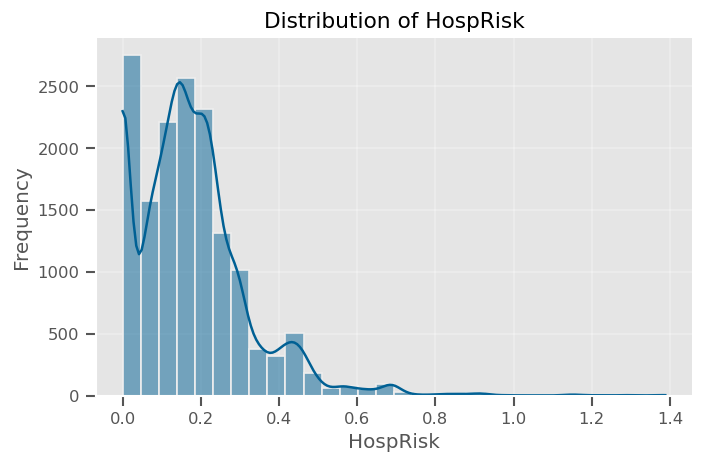

In [87]:
plot_target_histograms(weekly_panel, date_col="Date", targets=('HospRisk',), per_state=True, agg_level=None)

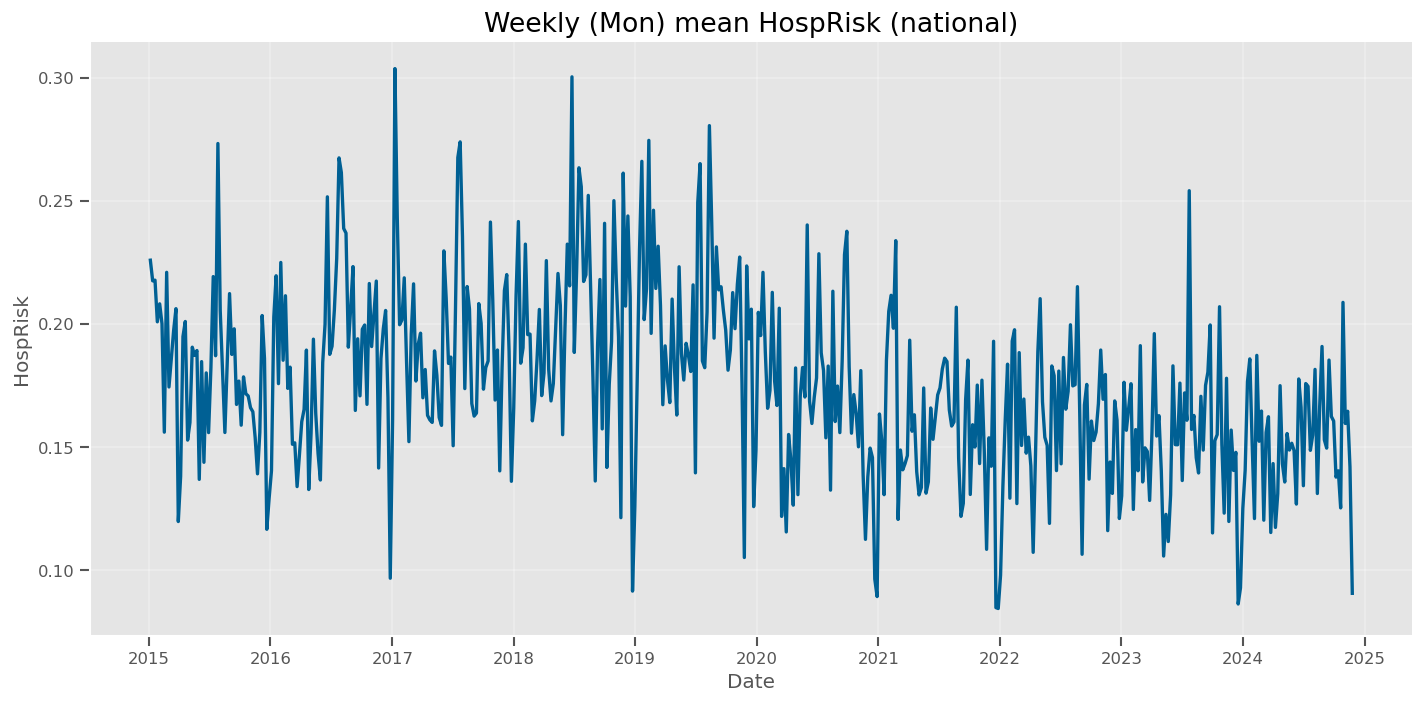

In [71]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def _format_week_axis(ax, year: int | None = None) -> None:
    """
    Weekly axis formatting.
    - If a single year is shown, label by month (compact).
    - Otherwise label by year (less clutter).
    """
    if year is not None:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    else:
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))


def plot_hosprisk_timeseries_weekly_monday(
    df: pd.DataFrame,
    date_col: str = "Date",
    target: str = "HospRisk",
    state_col: str = "State",
    agg: str = "mean",
    per_state: bool = False,
    facet: bool = True,
    state: str | None = None,
    year: int | None = None,
    ncols: int = 6,
    sharey: bool = True,
    figsize_per_col: float = 3.0,
    figsize_per_row: float = 2.2,
    check_monday: bool = True,  # <- new (optional)
) -> None:
    """
    Plot HospRisk time series from a weekly panel (week starts Monday).

    Assumes dates are already weekly Mondays. If check_monday=True,
    raises if any timestamp is not a Monday.
    """

    df_ = df.copy()
    df_[date_col] = pd.to_datetime(df_[date_col])

    if check_monday:
        # Monday = 0
        bad = df_.loc[df_[date_col].dt.weekday != 0, date_col]
        if not bad.empty:
            ex = bad.iloc[0]
            raise ValueError(
                f"{date_col} is not strictly weekly-Monday. "
                f"Example non-Monday date: {ex} (weekday={ex.weekday()}). "
                "Set check_monday=False to skip this check."
            )

    # ==========================================================
    # Single state override
    # ==========================================================
    if state is not None:
        g = df_.loc[df_[state_col] == state].sort_values(date_col)

        if year is not None:
            g = g.loc[g[date_col].dt.year == year]

        if g.empty:
            raise ValueError(f"No data for state={state!r}, year={year!r}.")

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(g[date_col], g[target], linewidth=2)

        title = f"Weekly (Mon) {target} — {state}"
        if year is not None:
            title += f" ({year})"

        ax.set_title(title, fontsize=16)
        ax.set_xlabel("Week" if year is not None else "Date")
        ax.set_ylabel(target)
        ax.grid(alpha=0.3)

        _format_week_axis(ax, year=year)

        plt.tight_layout()
        plt.show()
        return

    # ==========================================================
    # National aggregation
    # ==========================================================
    if not per_state:
        agg_df = (
            df_
            .groupby(date_col)[target]
            .agg(agg)
            .sort_index()
        )

        if year is not None:
            agg_df = agg_df.loc[agg_df.index.year == year]

        if agg_df.empty:
            raise ValueError(f"No data for year={year!r}.")

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(agg_df.index, agg_df.values, linewidth=2)

        title = f"Weekly (Mon) {agg} {target} (national)"
        if year is not None:
            title += f" ({year})"

        ax.set_title(title, fontsize=16)
        ax.set_xlabel("Week" if year is not None else "Date")
        ax.set_ylabel(target)
        ax.grid(alpha=0.3)

        _format_week_axis(ax, year=year)

        plt.tight_layout()
        plt.show()
        return

    # ==========================================================
    # Per-state plots
    # ==========================================================
    states = sorted(df_[state_col].unique())

    # -------------------------- faceted --------------------------
    if facet:
        n = len(states)
        nrows = math.ceil(n / ncols)

        fig_w = ncols * figsize_per_col
        fig_h = nrows * figsize_per_row

        fig, axes = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(fig_w, fig_h),
            sharex=True,
            sharey=sharey,
        )
        axes = axes.ravel()

        for i, st in enumerate(states):
            ax = axes[i]
            g = df_.loc[df_[state_col] == st].sort_values(date_col)

            if year is not None:
                g = g.loc[g[date_col].dt.year == year]

            ax.plot(g[date_col], g[target], linewidth=1.2)
            ax.set_title(st, fontsize=9)
            ax.grid(alpha=0.25)
            ax.tick_params(axis="x", labelsize=7)
            ax.tick_params(axis="y", labelsize=7)

            _format_week_axis(ax, year=year)

        # Disable unused panels
        for j in range(i + 1, len(axes)):
            axes[j].axis("off")

        main_title = f"Weekly (Mon) {target} by {state_col}"
        if year is not None:
            main_title += f" ({year})"

        fig.suptitle(main_title, fontsize=14, y=1.02)
        fig.text(0.5, 0.01, "Week" if year is not None else "Date", ha="center")
        fig.text(0.01, 0.5, target, va="center", rotation="vertical")

        plt.tight_layout()
        plt.show()
        return

    # -------------------------- overlaid --------------------------
    fig, ax = plt.subplots(figsize=(12, 6))

    for st in states:
        g = df_.loc[df_[state_col] == st].sort_values(date_col)
        if year is not None:
            g = g.loc[g[date_col].dt.year == year]
        ax.plot(g[date_col], g[target], alpha=0.5)

    title = f"Weekly (Mon) {target} per {state_col}"
    if year is not None:
        title += f" ({year})"

    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Week" if year is not None else "Date")
    ax.set_ylabel(target)
    ax.grid(alpha=0.3)

    _format_week_axis(ax, year=year)

    plt.tight_layout()
    plt.show()

plot_hosprisk_timeseries_weekly_monday(weekly_panel)

In [ ]:


def plot_hosprisk_small_multiples(
    panel: pd.DataFrame,
    states: list[str] | None = None,
    date_col: str = "Date",
    state_col: str = "State",
    value_col: str = "HospRisk",
    start: str | None = None,
    end: str | None = None,
    ncols: int = 4,
) -> None:
    df = panel.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    if states is None:
        states = sorted(df[state_col].unique())
    else:
        states = list(states)

    # optional date range
    if start is not None:
        df = df[df[date_col] >= pd.to_datetime(start)]
    if end is not None:
        df = df[df[date_col] <= pd.to_datetime(end)]

    df = df[df[state_col].isin(states)].sort_values([state_col, date_col])

    n = len(states)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, st in enumerate(states):
        ax = axes[i]
        g = df[df[state_col] == st]
        ax.plot(g[date_col], g[value_col], alpha=0.9)
        ax.set_title(st, fontsize=10)
        ax.tick_params(axis="x", labelsize=8, rotation=30)
        ax.grid(alpha=0.2)

    for j in range(n, len(axes)):
        axes[j].axis("off")

    fig.suptitle("HospRisk over time by state", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()


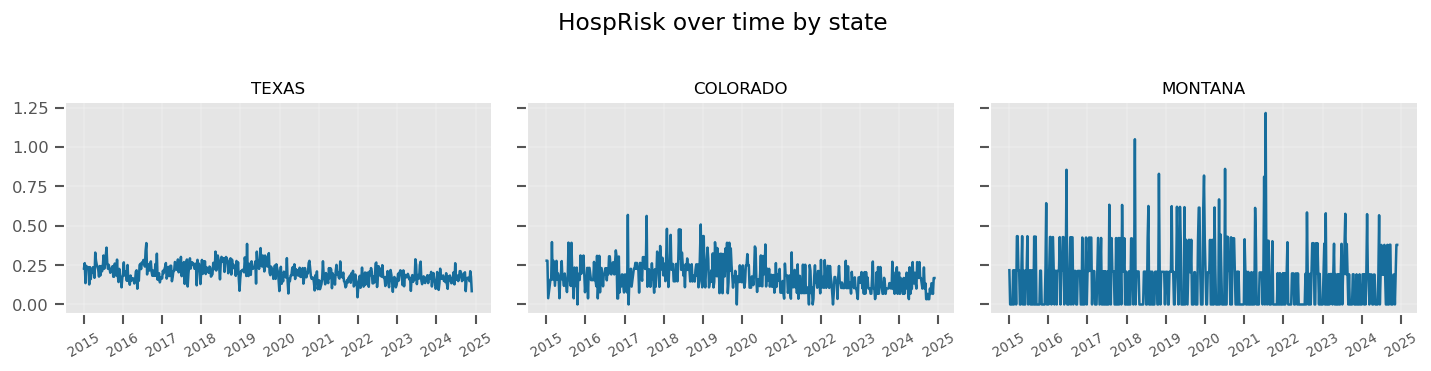

In [64]:
plot_hosprisk_small_multiples(weekly_panel, states=['TEXAS', 'COLORADO', 'MONTANA'], ncols=3)

In [92]:
weekly_panel.head()

,State,Date,HospRisk
0,ALABAMA,2015-01-05,0.051048
1,ALABAMA,2015-01-12,0.255184
2,ALABAMA,2015-01-19,0.255128
3,ALABAMA,2015-01-26,0.153043
4,ALABAMA,2015-02-02,0.255036


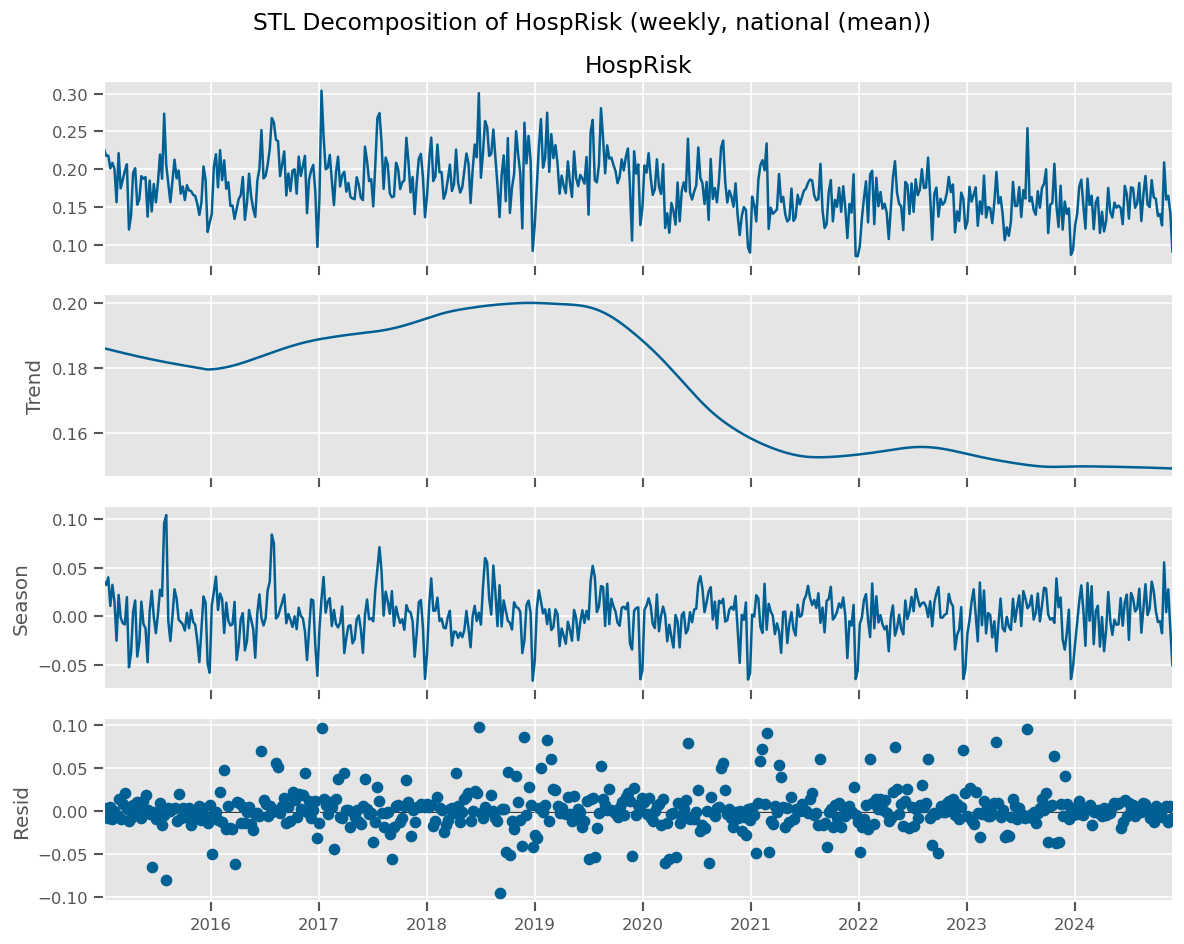

In [94]:

from statsmodels.tsa.seasonal import STL


def stl_decompose(
    df: pd.DataFrame,
    date_col: str = "Date",
    value_col: str = "HospRisk",
    agg_level: str = "monthly",   # "monthly" or "weekly"
    agg: str = "mean",            # mean for HospRisk; sum for counts
    period: int | None = None,    # 12 monthly, 52 weekly
    plot: bool = True,
    state_col: str = "State",
    state: str | None = None,     # if set -> decompose that state
    robust: bool = True,
):
    """
    STL decomposition for an already-prepared panel at monthly/weekly frequency.

    If state is None:
        aggregates across states by Date (using `agg`) -> national series.
    If state is provided:
        filters to that state -> state series.

    Returns
    -------
    result : STL fit result (statsmodels)
    """
    df_ = df.copy()
    df_[date_col] = pd.to_datetime(df_[date_col])

    level = agg_level.lower()
    if level in {"monthly", "month", "m"}:
        freq = "MS"
        default_period = 12
    elif level in {"weekly", "week", "w"}:
        freq = "W-MON"
        default_period = 52
    else:
        raise ValueError(f"Unsupported agg_level: {agg_level!r}. Use 'monthly' or 'weekly'.")

    if period is None:
        period = default_period

    # --- build the series (no resampling; data is already prepared) ---
    if state is not None:
        ts = (
            df_.loc[df_[state_col] == state, [date_col, value_col]]
               .sort_values(date_col)
               .set_index(date_col)[value_col]
        )
        if ts.empty:
            raise ValueError(f"No data for state={state!r}.")
        who = state
    else:
        ts = (
            df_.groupby(date_col)[value_col]
               .agg(agg)
               .sort_index()
        )
        who = f"national ({agg})"

    # --- ensure a regular index & no NaNs (STL requires this) ---
    full_idx = pd.date_range(ts.index.min(), ts.index.max(), freq=freq)
    ts = ts.reindex(full_idx)
    if ts.isna().any():
        ts = ts.interpolate(limit_direction="both")

    stl = STL(ts, period=period, robust=robust)
    result = stl.fit()

    if plot:
        fig = result.plot()
        fig.set_size_inches(10, 8)
        fig.suptitle(
            f"STL Decomposition of {value_col} ({agg_level}, {who})",
            fontsize=14
        )
        plt.tight_layout()
        plt.show()

    return result
stl_result_wk = stl_decompose(
    weekly_panel, period=52, agg_level="weekly", agg="mean")

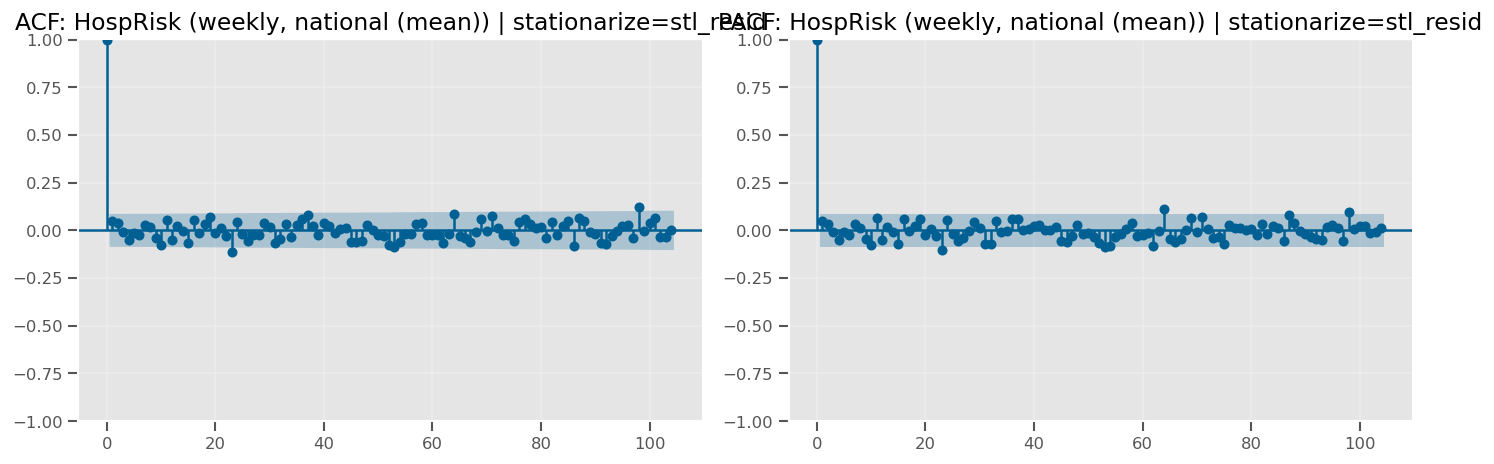

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(
    df: pd.DataFrame,
    date_col: str = "Date",
    value_col: str = "HospRisk",
    agg_level: str = "monthly",      # "monthly" or "weekly"
    agg: str = "mean",               # mean for HospRisk; sum for counts
    state_col: str = "State",
    state: str | None = None,        # if set -> single state
    lags: int | None = None,
    alpha: float = 0.05,
    pacf_method: str = "ywm",        # robust default in statsmodels
    stationarize: str = "none",      # "none" | "diff" | "seasdiff" | "diff+seasdiff" | "stl_resid"
) -> None:
    """
    Plot ACF and PACF for a monthly/weekly panel series (national aggregate or single state).
    Optionally stationarize before computing ACF/PACF.

    stationarize:
      - "none": raw series
      - "diff": first difference
      - "seasdiff": seasonal difference (12 for monthly, 52 for weekly)
      - "diff+seasdiff": first + seasonal difference
      - "stl_resid": STL residuals (removes trend + seasonality)
    """

    df_ = df.copy()
    df_[date_col] = pd.to_datetime(df_[date_col])

    level = agg_level.lower()
    if level in {"monthly", "month", "m"}:
        freq = "MS"
        default_lags = 24
        season_period = 12
    elif level in {"weekly", "week", "w"}:
        freq = "W-MON"
        default_lags = 104
        season_period = 52
    else:
        raise ValueError(f"Unsupported agg_level: {agg_level!r}. Use 'monthly' or 'weekly'.")

    if lags is None:
        lags = default_lags

    # Build series (no resampling; your panel is already at freq)
    if state is not None:
        ts = (
            df_.loc[df_[state_col] == state, [date_col, value_col]]
               .sort_values(date_col)
               .set_index(date_col)[value_col]
        )
        if ts.empty:
            raise ValueError(f"No data for state={state!r}.")
        who = state
    else:
        ts = (
            df_.groupby(date_col)[value_col]
               .agg(agg)
               .sort_index()
        )
        who = f"national ({agg})"

    # Ensure regular spacing and no NaNs
    full_idx = pd.date_range(ts.index.min(), ts.index.max(), freq=freq)
    ts = ts.reindex(full_idx)
    if ts.isna().any():
        ts = ts.interpolate(limit_direction="both")

    # --- Stationarize ---
    st = stationarize.lower()
    ts_used = ts.copy()
    label = f"{value_col} ({agg_level}, {who})"

    if st == "none":
        pass

    elif st == "diff":
        ts_used = ts_used.diff()

    elif st == "seasdiff":
        ts_used = ts_used.diff(season_period)

    elif st in {"diff+seasdiff", "seasdiff+diff"}:
        ts_used = ts_used.diff(season_period).diff()

    elif st == "stl_resid":
        # STL assumes a stable seasonal period; robust helps with outliers
        stl = STL(ts_used, period=season_period, robust=True)
        res = stl.fit()
        ts_used = res.resid

    else:
        raise ValueError(
            "stationarize must be one of: "
            "'none', 'diff', 'seasdiff', 'diff+seasdiff', 'stl_resid'"
        )

    ts_used = ts_used.dropna()

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plot_acf(ts_used, lags=lags, alpha=alpha, ax=axes[0])
    axes[0].set_title(f"ACF: {label} | stationarize={st}")

    plot_pacf(ts_used, lags=lags, alpha=alpha, method=pacf_method, ax=axes[1])
    axes[1].set_title(f"PACF: {label} | stationarize={st}")

    for ax in axes:
        ax.grid(alpha=0.25)

    plt.tight_layout()
    plt.show()

    
plot_acf_pacf(
    weekly_panel,
    agg_level="weekly",
    state=None,
    stationarize="stl_resid"
)

In [96]:
from src.features import build_panel_features

X_wk, y_wk, meta_wk = build_panel_features(
    panel_df=weekly_panel,
    target="HospRisk",
    group_col="State",
    date_col="Date",
    freq="W-MON",
    add_calendar=True,
    add_lags=True,
    add_rolling=True,
    add_ewm=True,
    lags=(1, 2, 4, 8, 12, 24, 52),
    rolling_windows=(12, 24, 52),
    ewm_spans=(12, 24, 52),
    dropna=True,
)

X_wk.head(), y_wk.head(), meta_wk.head()


(   year  month  quarter  week_sin  week_cos  HospRisk_lag1  HospRisk_lag2  \
 0  2016      1        1  0.120537  0.992709       0.150879       0.201218   
 1  2016      1        1  0.239316  0.970942       0.402287       0.150879   
 2  2016      1        1  0.354605  0.935016       0.502842       0.402287   
 3  2016      1        1  0.464723  0.885456       0.251412       0.502842   
 4  2016      2        1  0.568065  0.822984       0.301685       0.251412   
 
    HospRisk_lag4  HospRisk_lag8  HospRisk_lag12  HospRisk_lag24  \
 0       0.100655       0.352751        0.252354        0.202700   
 1       0.000000       0.201501        0.403606        0.455841   
 2       0.201218       0.201430        0.302584        0.354393   
 3       0.150879       0.251699        0.050411        0.354324   
 4       0.402287       0.100655        0.352751        0.253039   
 
    HospRisk_lag52  HospRisk_rollmean12  HospRisk_rollmean24  \
 0        0.051048             0.205757             0.22

In [97]:
print(X_wk.shape, y_wk.shape, meta_wk.shape)

(13950, 18) (13950,) (13950, 2)


In [98]:
y_wk.max()

1.3880596999387391

In [3]:
from src.RQ1_utils import yearly_train_ends, rolling_origin_masks

In [ ]:


train_ends = yearly_train_ends(meta_wk, date_col="Date")
splits = rolling_origin_masks(meta_wk, date_col="Date", train_ends=train_ends, test_size=52)

len(train_ends), len(splits)


(9, 8)

In [100]:
split_calendar = pd.DataFrame([
    {
        "train_end": s["train_end"].date(),
        "test_start": s["test_start"].date(),
        "test_end": s["test_end"].date(),
        "train_weeks": s["n_train_weeks"],
        "test_weeks": s["n_test_weeks"],
        "train_rows": s["n_train_rows"],
        "test_rows": s["n_test_rows"],
    }
    for s in splits
])

split_calendar.head(10)


,train_end,test_start,test_end,train_weeks,test_weeks,train_rows,test_rows
0,2016-12-26,2017-01-02,2017-12-25,52,52,1560,1560
1,2017-12-25,2018-01-01,2018-12-24,104,52,3120,1560
2,2018-12-31,2019-01-07,2019-12-30,157,52,4710,1560
3,2019-12-30,2020-01-06,2020-12-28,209,52,6270,1560
4,2020-12-28,2021-01-04,2021-12-27,261,52,7830,1560
5,2021-12-27,2022-01-03,2022-12-26,313,52,9390,1560
6,2022-12-26,2023-01-02,2023-12-25,365,52,10950,1560
7,2023-12-25,2024-01-01,2024-11-25,417,48,12510,1440


In [101]:
# train_end dates to keep
keep_train_ends = {
    pd.Timestamp("2018-12-31"),
    pd.Timestamp("2019-12-30"),
    pd.Timestamp("2020-12-28"),
    pd.Timestamp("2021-12-27"),
    pd.Timestamp("2022-12-26"),
    pd.Timestamp("2023-12-25"),
}

# filter splits
splits_origins = [
    s for s in splits
    if pd.Timestamp(s["train_end"]) in keep_train_ends
]

len(splits_origins), [s["train_end"].date() for s in splits_origins]


(6,
 [datetime.date(2018, 12, 31),
  datetime.date(2019, 12, 30),
  datetime.date(2020, 12, 28),
  datetime.date(2021, 12, 27),
  datetime.date(2022, 12, 26),
  datetime.date(2023, 12, 25)])

In [45]:
from src.models import get_model_configs, instantiate_models
from src.training import fit_global_models

In [124]:
from src.RQ1_utils import run_global


In [125]:
from src.config import RESULTS_DIR

In [127]:
horizons = [1, 4, 13]

preds_wk, metrics_wk, perm_wk = run_global(
    X=X_wk,
    y=y_wk,
    meta=meta_wk,
    splits=splits_origins,
    horizons=horizons,
    group_col="State",
    date_col="Date",
    seasonal_period=52,
    use_linear=True,
    use_tree=True,
    compute_perm_importance=True,          
    savedir=RESULTS_DIR,          
    run_name="weekly_global_no_exg",
)


In [129]:
# how many TRAIN rows were stored per split/horizon/model
train_counts = (
    preds_wk.query("set == 'train'")
          .groupby(["split_id", "train_end", "horizon", "model"])
          .size()
          .reset_index(name="n_rows")
)

# view one model only (easier to read), e.g. Ridge if present
train_counts[train_counts["model"].str.contains("Ridge", case=False, na=False)].sort_values(["train_end","horizon"])


,split_id,train_end,horizon,model,n_rows
5,1,2018-12-31,1,Ridge,4710
12,1,2018-12-31,4,Ridge,4710
19,1,2018-12-31,13,Ridge,4710
26,2,2019-12-30,1,Ridge,6270
33,2,2019-12-30,4,Ridge,6270
40,2,2019-12-30,13,Ridge,6270
47,3,2020-12-28,1,Ridge,7830
54,3,2020-12-28,4,Ridge,7830
61,3,2020-12-28,13,Ridge,7830
68,4,2021-12-27,1,Ridge,9390


In [131]:
metrics_wk.query("set == 'test'").sort_values(["train_end","horizon","MASE"]).head(20)


,split_id,train_end,horizon,model,set,n_rows,MAE,RMSE,MASE
14,1,2018-12-31,1,CatBoost,test,1560,0.102361,0.142376,0.784250
2,1,2018-12-31,1,Ridge,test,1560,0.102682,0.142896,0.789185
6,1,2018-12-31,1,ElasticNet,test,1560,0.102702,0.142640,0.789799
10,1,2018-12-31,1,XGBoost,test,1560,0.103282,0.144712,0.789892
8,1,2018-12-31,1,PLS,test,1560,0.102716,0.142726,0.790139
4,1,2018-12-31,1,Lasso,test,1560,0.102778,0.142558,0.791112
12,1,2018-12-31,1,LightGBM,test,1560,0.103310,0.145672,0.791269
0,1,2018-12-31,1,Seasonal Naive,test,1560,0.135985,0.202662,1.020933
29,1,2018-12-31,4,CatBoost,test,1560,0.103721,0.144002,0.796925
17,1,2018-12-31,4,Ridge,test,1560,0.103828,0.142468,0.800560


In [132]:
from src.RQ1_utils import (
    summarize_metrics_mean_std,
    plot_stability_across_splits,
    plot_fit_and_forecast,
    plot_rmse_per_fold,
    
)

In [133]:
weekly_h1 = summarize_metrics_mean_std(metrics_wk, horizon=1)

weekly_h1

,RMSE,MAE,MASE
model,,,
CatBoost,0.127 ± 0.010,0.091 ± 0.007,0.703 ± 0.045
ElasticNet,0.127 ± 0.010,0.091 ± 0.007,0.704 ± 0.048
Lasso,0.127 ± 0.010,0.091 ± 0.007,0.705 ± 0.048
LightGBM,0.128 ± 0.011,0.092 ± 0.007,0.708 ± 0.048
PLS,0.127 ± 0.010,0.091 ± 0.007,0.703 ± 0.048
Ridge,0.127 ± 0.010,0.091 ± 0.007,0.703 ± 0.048
Seasonal Naive,0.181 ± 0.014,0.122 ± 0.009,0.945 ± 0.053
XGBoost,0.128 ± 0.011,0.092 ± 0.007,0.708 ± 0.048


In [135]:
weekly_h4 = summarize_metrics_mean_std(metrics_wk, horizon=4)
weekly_h4

,RMSE,MAE,MASE
model,,,
CatBoost,0.127 ± 0.010,0.091 ± 0.007,0.706 ± 0.049
ElasticNet,0.127 ± 0.009,0.091 ± 0.007,0.707 ± 0.050
Lasso,0.127 ± 0.009,0.091 ± 0.007,0.708 ± 0.051
LightGBM,0.128 ± 0.010,0.092 ± 0.007,0.710 ± 0.050
PLS,0.127 ± 0.009,0.091 ± 0.007,0.707 ± 0.051
Ridge,0.127 ± 0.009,0.091 ± 0.007,0.707 ± 0.050
Seasonal Naive,0.181 ± 0.015,0.122 ± 0.010,0.944 ± 0.058
XGBoost,0.128 ± 0.011,0.092 ± 0.008,0.712 ± 0.051


In [136]:
weekly_h13 = summarize_metrics_mean_std(metrics_wk, horizon=13)
weekly_h13

,RMSE,MAE,MASE
model,,,
CatBoost,0.126 ± 0.010,0.091 ± 0.007,0.703 ± 0.051
ElasticNet,0.126 ± 0.009,0.091 ± 0.007,0.704 ± 0.050
Lasso,0.126 ± 0.009,0.091 ± 0.007,0.704 ± 0.051
LightGBM,0.126 ± 0.010,0.091 ± 0.008,0.705 ± 0.053
PLS,0.126 ± 0.009,0.091 ± 0.007,0.704 ± 0.051
Ridge,0.126 ± 0.009,0.091 ± 0.007,0.704 ± 0.049
Seasonal Naive,0.179 ± 0.013,0.121 ± 0.009,0.940 ± 0.056
XGBoost,0.127 ± 0.010,0.091 ± 0.008,0.705 ± 0.053


In [137]:
from src.config import RESULTS_DIR

In [138]:
weekly_h1.to_csv(RESULTS_DIR / "weekly_metrics_h1.csv")
weekly_h4.to_csv(RESULTS_DIR / 'weekly_metrics_h4.csv')
weekly_h13.to_csv(RESULTS_DIR / "weekly_metrics_h13.csv")

print(f"Saved weekly summary tables to {RESULTS_DIR.resolve()}")

Saved weekly summary tables to C:\Users\esper\Desktop\injury_forecasting\results


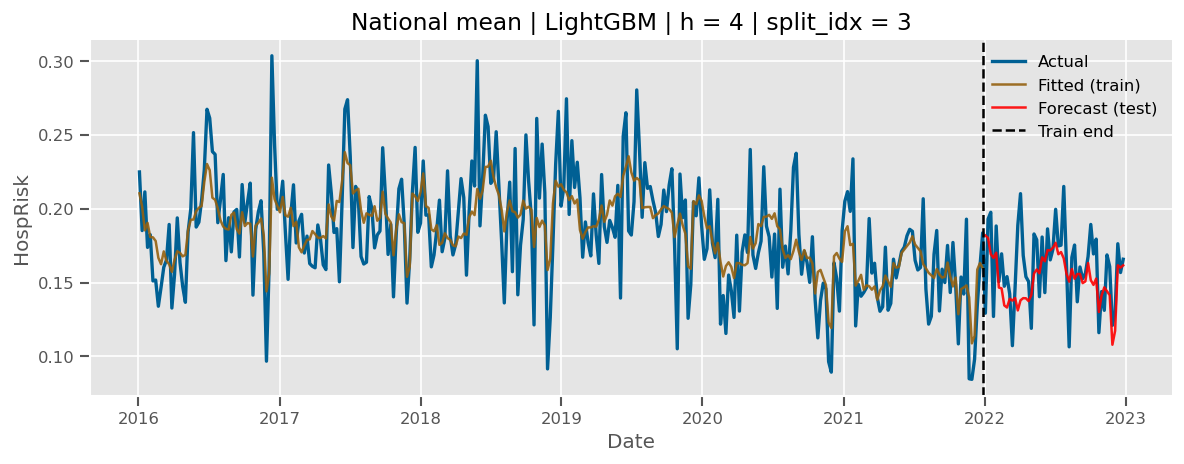

In [143]:
plot_fit_and_forecast(preds_wk, "LightGBM", split_idx=3, horizon=4)

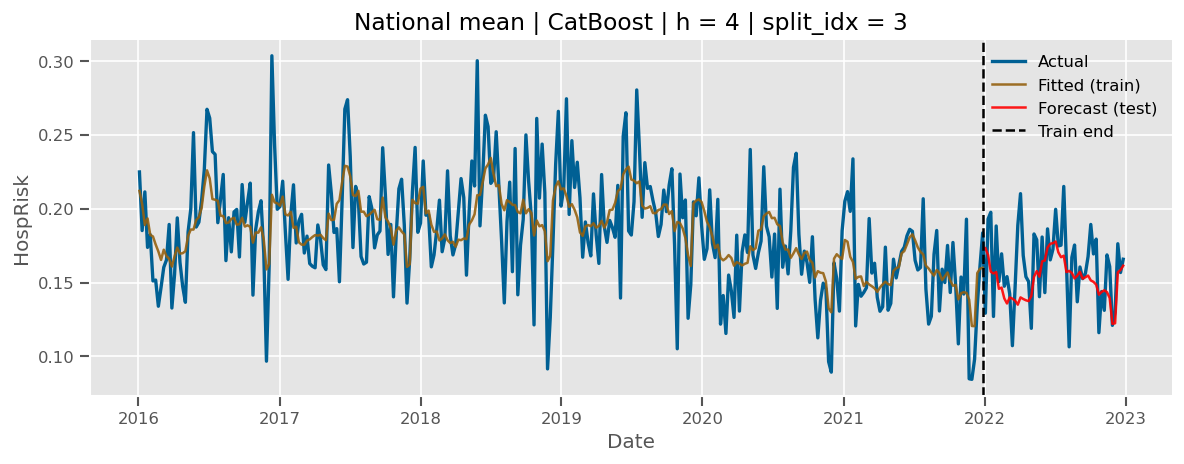

In [144]:
plot_fit_and_forecast(preds_wk, "CatBoost", split_idx=3, horizon=4)